In [1]:
root_folder = '/ASTRA/'

In [2]:
!pwd

/ASTRA/notebook


In [3]:
import numpy as np
import numpy.ma as ma
import os
import h5py
from skimage import io
import matplotlib
import matplotlib.pyplot as plt 
import pandas as pd
import math
import time
import sys
import pickle
from visdom import Visdom

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

from collections import defaultdict
from sklearn.metrics import f1_score
import cv2
import pandas as pd
import h5py

############### Visualization

from ipywidgets import Button, Layout
import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display,clear_output,Video
from copy import copy
import numpy.ma as ma
import matplotlib.colors as colors
import imageio


sys.path.insert(0,root_folder+'ASTRA/modules/')
from gen_single_astro  import filt_im
from sel_active_reg_gen import *
from model.dense_up import dense_up

from test_fun import gen_sc_mask,fix_mask,prob_calc,small_soma_to_proc,common_merge,art_rem_large,art_rem

from get_traces import *#update_dict_DNN
from gui_results import layout
from mask_roi_from_fiji import create_mask

# model to import
model = dense_up(3)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device1 = torch.device('cpu')#('cuda:1' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


###
MAX_ROI_AREA_PROC=50
MU_PX = 1
DOMAIN_RADIUS = 60
# motion corr in extracting traces
motion_corr=True

In [4]:
from joblib import Parallel, delayed

In [5]:
#PARAMS
N=256
M=256

fov_DNN_weights_folder = root_folder+'/weights/dense_up' 
set_dir=root_folder+'/set1/'

In [6]:
class SimDataset_test(Dataset):
    def __init__(self,image_set):
        self.input_images = image_set    


    def __len__(self):
        return len(self.input_images)

    def __getitem__(self, idx):        
        image = self.input_images[idx]
        image = torch.from_numpy(image).float()

        return image

    
vis_flag = False
##### LOAD PARAM DICT
with open(set_dir+'/dict_dataset1.txt', "rb") as fp:   #Pickling
    dict_param = pickle.load(fp)
max_min = dict_param['max_min']
dict_param

{'list': [0, 40, 80, 120, 160],
 'blocks': 15,
 'threads': 32,
 'BPM_ratio': 3,
 'bb': 96,
 'N_pix_st': 100,
 'astr_min': 80,
 'percentile': 80,
 'pad': 5,
 'astro_num': 4,
 'init_th_': 0.6,
 'decr_dim': 10,
 'decr_th': 25,
 'corr_int': False,
 'gpu_flag': True,
 'th1_p': 0.25,
 'th2_p': 0.1,
 'max_min': [345, 89]}

In [7]:
dict_param = {
    'list':[0,40,80,120,160],
    'blocks':15,
    'threads':32,
    'BPM_ratio':3,
    'bb':96,
    'N_pix_st':100, #starting minimum area
    'astr_min':80, # approx. 0.9 min in dataset
    'percentile': 80,
    'pad':5,
    'astro_num':4, # number of astro min in FOV
    'init_th_':0.6, # threshold initialization
    'decr_dim':10, # astro area decrease
    'decr_th':25, # temporal threshold decrease
    'corr_int':False, # intensity correction flag
    'gpu_flag':True
}

In [8]:
fov_list=[1]

In [9]:
for jj in fov_list:
    import time
    t1 = time.time()
    #im_list = []
    Res_1 = np.zeros((N,M,3))

    test_folder_str =str(jj)
    if len(test_folder_str)==1:
        test_folder_str1='00'+test_folder_str
    else:
        test_folder_str1='0'+test_folder_str
print(test_folder_str1)

001


In [10]:
dict_im = {}
dict_im['Astro_domain_radius'] = DOMAIN_RADIUS
for jj in fov_list:
    import time
    t1 = time.time()
    #im_list = []
    Res_1 = np.zeros((N,M,3))

    test_folder_str =str(jj)
    if len(test_folder_str)==1:
        test_folder_str1='00'+test_folder_str
    else:
        test_folder_str1='0'+test_folder_str
    
    print('weights:',fov_DNN_weights_folder+test_folder_str1+'D1.pt')
    model.load_state_dict(torch.load(fov_DNN_weights_folder+test_folder_str1+'D1.pt'))
    
    #collect stack to analyze
    
    stack_dir = root_folder+'/set1/'+test_folder_str1+'/'

    items_stack = os.listdir(stack_dir)

    print(stack_dir + items_stack[0])
    stack = io.imread(stack_dir + items_stack[0]).astype(np.uint16)
    dict_im['t-series_'+test_folder_str1] = stack
    frames,_,_ = stack.shape

    a_reg = sel_active_reg(stack.astype(np.float32),dict_param)
    mask = a_reg.get_mask(long_rec=False)
    mask = fix_mask(mask)
    
    #im_list.append([mask,'Active Regions'])
    dict_im['Active Regions_'+test_folder_str1] = mask
    
    filter_ = filt_im(stack_dir + items_stack[0],mask,dict_param['bb']-2*dict_param['pad'])
    _, image_to_plot = filter_.create_img()
    
    # for other dataset spatia_pp methods can be called from filter_, outputs are stack filtered and spatial map enhanced  
    #im_list.append([image_to_plot,'Enhanced'])
    dict_im['Enhanced_'+test_folder_str1] = image_to_plot
    coord_l = filter_.get_instances()
    
    assert coord_l!=0, 'Check Active region extraction module'
    
    
    image_stack = np.empty((len(coord_l),dict_param['bb'],dict_param['bb'])) 

    image_stack,filt_imageL = filter_.save_im()#select the padding val 5 is default
    
    
    image_set = image_stack[:,0,:,:]
    image_set = image_set[:,np.newaxis,:,:]

    imageL_set = image_to_plot*filt_imageL
    imageL_set-=np.mean(imageL_set)
    imageL_set= imageL_set[np.newaxis,np.newaxis,:,:]



    model.eval()   # Set model to evaluate mode
    ######################################## Prob Map
    test_datasetL = SimDataset_test(imageL_set)
    test_loader = DataLoader(test_datasetL, batch_size=15, shuffle=False, num_workers=0)

    inputs = next(iter(test_loader))
    inputs = inputs.to(device)
    pred = model(inputs)
    
    pred_mean = pred.data.cpu().numpy()
    del test_datasetL,test_loader, inputs,pred
    
    mean = pred_mean[0]
    maxim = np.amax(mean,axis=0)
    mean[mean<maxim]=0
        
    prob_mapPL,sm_ent = prob_calc(mean[1,:,:],max_min[0],max_min[1])
    
    #im_list.append([prob_mapPL,'Prob. Map'])
    dict_im['Prob. Map PL_'+test_folder_str1] = prob_mapPL
    #im_list.append([sm_ent,'Prob. Map'])
    dict_im['Prob. Map_'+test_folder_str1] = sm_ent
    ########################################## putative single cell
    test_dataset_S = SimDataset_test(image_set)
    test_loader = DataLoader(test_dataset_S, batch_size=15, shuffle=False, num_workers=0)

    
    pred_mean=[]
    for inputs in test_loader:
        inputs = inputs.to(device)

        pred = model(inputs)
        pred_mean.append(pred.data.cpu().numpy())
        del inputs,pred

    torch.cuda.empty_cache()
    
    for j in range(1,len(pred_mean)):
        pred_mean[0]=np.vstack((pred_mean[0],pred_mean[j]))

    prob_map = np.zeros((N,M,2))

    for i in range(len(coord_l)):
        mean= np.zeros((3,dict_param['bb'],dict_param['bb']))
        mean = pred_mean[0][i,:,:,:].copy()
        
        maxim = np.amax(mean,axis=0)
        mean[mean<maxim]=0
        mean[mean>=maxim]=1

        small_soma = small_soma_to_proc(mean[1,:,:],N = int((2/3)*max_min[1])) ####remove too small somata segmentated
        mean[0,:,:]+=small_soma
        mean[1,:,:]-=small_soma
        
        coord = coord_l[i]
        Res_1[coord[1]:coord[3],coord[0]:coord[2],0] += mean[0,dict_param['pad']:-dict_param['pad'],dict_param['pad']:-dict_param['pad']]
        Res_1[coord[1]:coord[3],coord[0]:coord[2],1] += mean[1,dict_param['pad']:-dict_param['pad'],dict_param['pad']:-dict_param['pad']]



    Res_1[:,:,0] -= Res_1[:,:,1]
    Res_1[Res_1<1]=0
    Res_1[Res_1>0]=1

    ######### can be wrapped
    
    soma_f = common_merge(Res_1[:,:,1],sm_ent)
    Res_1[:,:,1]=soma_f

    #remove possible artifacts
    small_soma = small_soma_to_proc(Res_1[:,:,1],int(0.9*max_min[1]),dilation=False)
    Res_1[:,:,1]-=small_soma

    Res_1[:,:,0] = Res_1[:,:,0]-Res_1[:,:,1]
    Res_1[Res_1<1]=0
    Res_1[Res_1>0]=1

    #remove large region classified as soma Area>500
    Res_1_filt,removal = art_rem_large(Res_1[:,:,1],Res_1[:,:,0],N=int(1.15*max_min[0]))
    if removal<2:
        Res_1-=Res_1_filt[:,:,np.newaxis]

    Res_1_filt,removal = art_rem_large(Res_1[:,:,1],Res_1[:,:,0],N=max_min[0])
    if removal<2:
        Res_1-=Res_1_filt[:,:,np.newaxis]


    #remove processes without soma
    Res_1_filt = art_rem(Res_1[:,:,1],Res_1[:,:,0])
    Res_1*=Res_1_filt[:,:,np.newaxis]
    
    dict_im['Final_Mask_'+test_folder_str1] = Res_1
    print(20*'%')
    #######################################################################################################
    #Visualization of images
    if vis_flag:
        vis = Visdom(port=8097, server="http://localhost",env='inference_plot')
        for key in dict_im.keys():
            if key in ['Active Regions_'+test_folder_str1,'Enhanced_'+test_folder_str1,'Final_Mask_'+test_folder_str1]:
                image = dict_im[key]
                fig, ax = plt.subplots(figsize=(4,4))
                ax.imshow(image)
                ax.axis('off')
                ax.set_title(key)
                vis.matplot(fig)
                plt.close(fig)
    
    #### Extraction
    single_astro_roi = gen_sc_mask(dict_im['Final_Mask_'+test_folder_str1])
    dict_im = update_dict_DNN(dict_im,single_astro_roi,test_folder_str1,motion_corr,MAX_ROI_AREA_PROC,MU_PX,MiniROI=True)
    #### save dict
    pickle.dump(dict_im, open( "inference_ex.pkl", "wb" ) )
    
    print(time.time()-t1)

weights: /ASTRA//weights/dense_up001D1.pt
/ASTRA//set1/001/TSeries-04082019-1513-1250_Ch2__movie_corrected_aligned (1).tiff
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    3.9s finished


Iteration per block:  1.0
GPU started with  (15, 15)  blocks and  (32, 32)  threads per block
Init threshold 330.0
NUM CComponents 291
Found iter 9
Zones 9
file loading...
check (550, 256, 256)
%%%%%%%%%%%%%%%%%%%%
ROI NUM 4
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 0
ROIS 3
SPLIT DONE (256, 256, 6)
Extraction: done
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 1
ROIS 5
SPLIT DONE (256, 256, 10)
Extraction: done
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 2
ROIS 5
SPLIT DONE (256, 256, 18)
Extraction: done
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 3
ROIS 3
SPLIT DONE (256, 256, 5)
Extraction: done
13.23057246208191


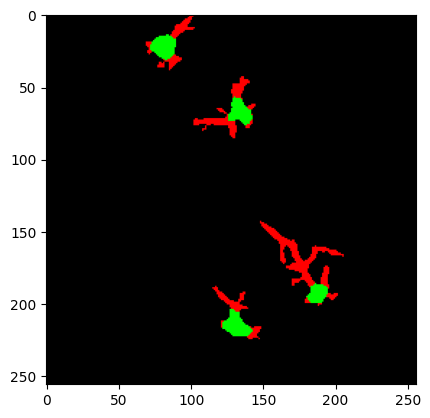

In [11]:
plt.imshow(Res_1)


In [34]:
dict_im.keys()

dict_keys(['Astro_domain_radius', 't-series_002', 'Active Regions_002', 'Enhanced_002', 'Prob. Map PL_002', 'Prob. Map_002', 'Final_Mask_002', 'Single_cell_mask_002', 'Cell_num_002', 'Signals_extr_002', 'ROI_002', 'crop_coord_ROI_002', 'shift_ROI_002', 'Final_Mask_fraction_002'])

In [35]:
dict_im['Signals_extr_002'].keys()

dict_keys(['Soma_000', 'Proc_000_000', 'Proc_000_001', 'Proc_000_002', 'Proc_000_003', 'Proc_000_004', 'Proc_000_005', 'Soma_001', 'Proc_001_000', 'Proc_001_001', 'Proc_001_002', 'Proc_001_003', 'Proc_001_004', 'Proc_001_005', 'Proc_001_006', 'Proc_001_007', 'Proc_001_008', 'Proc_001_009', 'Proc_001_010', 'Soma_002', 'Proc_002_000', 'Proc_002_001', 'Proc_002_002', 'Proc_002_003', 'Proc_002_004', 'Proc_002_005', 'Proc_002_006', 'Proc_002_007', 'Proc_002_008', 'Soma_003', 'Proc_003_000', 'Proc_003_001', 'Proc_003_002', 'Proc_003_003', 'Proc_003_004', 'Proc_003_005', 'Soma_004', 'Proc_004_000', 'Proc_004_001', 'Proc_004_002', 'Proc_004_003', 'Proc_004_004', 'Proc_004_005'])

In [36]:
print(motion_corr,MAX_ROI_AREA_PROC,MU_PX)

True 50 1


# Visualization of results

In [37]:
fov_name = []
for j in fov_list:
    j = str(j)
    if len(j)==1:
        j='00'+j
    else:
        j='0'+j
    fov_name.append(j)
fov_name
hbox,button,display_plot = layout(fov_name,dict_im)
display(hbox)
button.on_click(display_plot)

# Manual curation
Export ROIs for ImageJ

In [38]:
from ROI_manual_curation import *

In [39]:
#export ROIs for ImageJ
export_roi(dict_im,fov_list,N=256,M=256,folder_save = '/media/DATA/jbonato/astro_segm/notebook/')

Attention: File  /media/DATA/jbonato/astro_segm/notebook/ROI_002_MC.zip  already present


In [14]:
#clean dictionary from ROIs and extracted traces
dict_im = clean_dict(dict_im,fov_list)

In [15]:
#update dict_im with the manual curated
for fov in fov_list:
    folder = f'{str(fov):0>3}'
    mask_ret = read_roi_curated(folder,N=256,M=256,folder_read='/media/DATA/jbonato/astro_segm/notebook/')
    dict_im = update_dict_DNN(dict_im,mask_ret,folder,motion_corr,MAX_ROI_AREA_PROC,MU_PX)
    #### save dict
    pickle.dump(dict_im, open( "inference_ex.pkl", "wb" ) )

ROI NUM 5
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 0
ROIS 4
SPLIT DONE (4, 256, 256)
Extraction: done
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 1
ROIS 1
SPLIT DONE (1, 256, 256)
(256, 256, 4) (256, 256, 1)
Extraction: done
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 2
ROIS 4
SPLIT DONE (4, 256, 256)
(256, 256, 5) (256, 256, 4)
Extraction: done
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 3
ROIS 3
SPLIT DONE (3, 256, 256)
(256, 256, 9) (256, 256, 3)
Extraction: done
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 4
ROIS 4
SPLIT DONE (4, 256, 256)
(256, 256, 12) (256, 256, 4)
Extraction: done
